In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        # transforms.Normalize(mean, std),
        # lambda x: torch.flip(x, [1]),
        # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)
trainset = torchvision.datasets.ImageFolder(
    root="./data/caltech-101",
    transform=transform,
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=False, num_workers=2
)

In [16]:
from cbir import *
from cbir.featuring.vgg16 import VGG16Extractor
from cbir.pipeline import *

rgb_histogram = RGBHistogram(n_bin=8, h_type="region")
resnet = ResNetExtractor(model = "resnet18", device="cuda")
# vgg16 = VGG16Extractor(device="cuda")
array_store = NPArrayStore(retrieve=KNNRetrieval(metric="cosine"))

cbir = CBIR(rgb_histogram, array_store)

In [17]:
for images, labels in tqdm(trainloader):
    images = images.numpy().transpose(0,2,3,1)
    cbir.indexing(images)

  0%|          | 0/72 [00:00<?, ?it/s]/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResi

In [21]:
img = Image.open("/home/edtechai/works/vunt/CV-basic/data/caltech-101/sunflower/image_0003.jpg")
img = transform(img)
img = img.numpy().transpose(1,2,0)

In [24]:
# rs = cbir.retrieve(np.expand_dims(img, axis=0), k=5)
rs = cbir.retrieve(img, k=5)

/home/edtechai/works/vunt/CV-basic/cbir/storage/nparray.py:50: RuntimeWarning: divide by zero encountered in scalar divide
  result.append(ImageSearchObject(image, 1/distance))


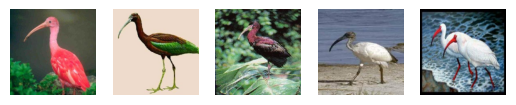

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,5)
for i, r in enumerate(rs):
    # ax[i].imshow(r.image.transpose((1, 2, 0)))
    ax[i].imshow(r.image)
    # ax[i].set_title(f"{r.distance}")
    ax[i].axis("off")
plt.show()

In [16]:
import torchvision.models as models

model = models.resnet152(pretrained=True)

/home/edtechai/miniconda3/envs/cbir/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/edtechai/miniconda3/envs/cbir/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[ 4.7132e-07,  6.3123e-07,  6.1915e-07,  ...,  2.9313e-07,
                          2.1123e-07,  1.3036e-07],
                        [ 4.8263e-07,  7.1548e-07,  7.1251e-07,  ...,  3.0581e-07,
                          2.6611e-07,  2.3413e-07],
                        [ 4.9888e-07,  6.3326e-07,  6.1920e-07,  ...,  1.2629e-07,
                          1.8429e-07,  2.0732e-07],
                        ...,
                        [ 5.5013e-07,  3.1735e-07,  4.1098e-07,  ...,  3.1079e-07,
                          3.4928e-07,  3.4718e-07],
                        [ 6.2982e-07,  4.0325e-07,  3.4432e-07,  ...,  4.8297e-07,
                          6.4529e-07,  5.4214e-07],
                        [ 7.1402e-07,  5.0883e-07,  4.4785e-07,  ...,  6.2946e-07,
                          6.5617e-07,  5.0979e-07]],
              
                       [[ 5.0878e-07,  6.8802e-07,  6.1782e-07,  ...,  2.2142e-07,
                          2.1541

In [1]:
import cv2
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import models

In [2]:
VGG = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
pretrained_model = VGG
pretrained_model.classifier = nn.Sequential(*list(VGG.classifier.children())[:-3])

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
pretrained_model = pretrained_model.eval()
pretrained_model = pretrained_model.cuda()

In [31]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for images, labels in tqdm(trainloader):
    images = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.Normalize(mean, std),
            lambda x: torch.flip(x, [1]),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]
    )(images)
    break


  0%|          | 0/72 [00:01<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.235808..4.28].


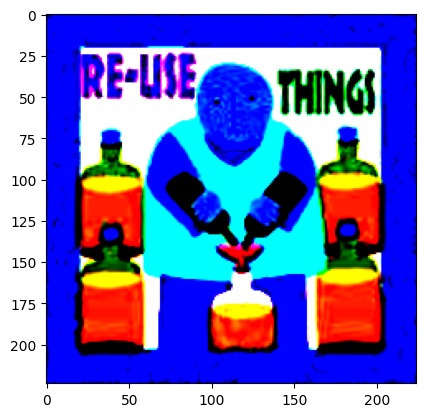

In [66]:
plt.imshow(images[0].numpy().transpose(1,2,0))

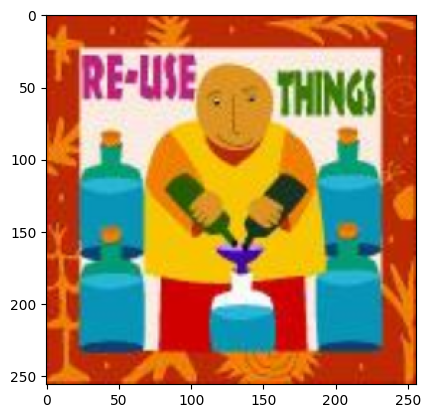

In [39]:
import matplotlib.pyplot as plt
plt.imshow(trainset[0][0].numpy().transpose(1,2,0))

In [52]:
preprocess_image(trainset[0][0].numpy().transpose(1,2,0))[0].shape

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 224, 224])

In [60]:
trainset[0][0].numpy().transpose(1,2,0).shape

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(256, 256, 3)

In [65]:
preprocess_image(trainset[0][0].numpy().transpose(1,2,0))[0].cpu().numpy().transpose(1,2,0).shape

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.7870152].


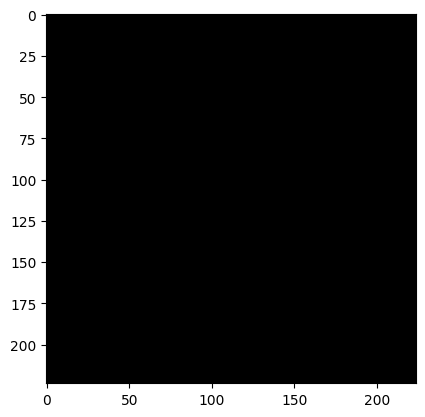

In [63]:
plt.imshow(preprocess_image(trainset[0][0].numpy().transpose(1,2,0))[0].cpu().numpy().transpose(1,2,0))


In [67]:
preprocess_image(trainset[0][0].permute(1,2,0).numpy())[0].cpu().numpy().transpose(1,2,0).shape

/home/edtechai/miniconda3/envs/yolov10/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(224, 224, 3)

In [54]:
img = cv2.imread("/home/edtechai/works/vunt/CV-basic/data/caltech-101/bass/image_0001.jpg")
img = preprocess_image(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.7870152].


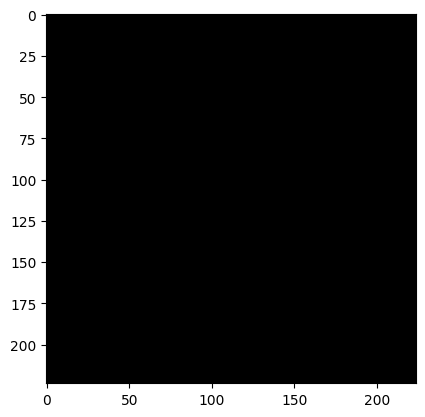

In [68]:
plt.imshow(preprocess_image(trainset[0][0].permute(1,2,0).numpy())[0].cpu().numpy().transpose(1,2,0))

In [4]:
def preprocess_image(cv2im, resize_im=True):
    # mean and std list for channels (ImageNet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # processing single channel pictures
    try:
        if len(cv2im.shape) != 3:
            temp = np.zeros((cv2im.shape[0], cv2im.shape[1], 3))
            temp[:, :, 0] = cv2im
            temp[:, :, 1] = cv2im
            temp[:, :, 2] = cv2im
            cv2im = temp
            cv2im = np.transpose(cv2im, (2, 0, 1))  # Reshape
    except Exception as e:
        print(e)
        print(e.__traceback__.tb_frame.f_globals["__file__"])
    if resize_im:
        cv2im = cv2.resize(cv2im, (224, 224))
    im_as_arr = np.float32(cv2im)
    im_as_arr = np.ascontiguousarray(im_as_arr[..., ::-1])
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. Tensor shape = 1,3,224,224
    im_as_ten.unsqueeze_(0)
    im_as_ten = im_as_ten.cuda()
    return im_as_ten

In [6]:
def get_feature(img_path):
    pretrained_model.eval()
    img = cv2.imread(img_path)
    img = preprocess_image(img)
    feature = pretrained_model(img)
    feature = feature.data.cpu().numpy()
    feature_norm = feature/np.linalg.norm(feature)
    #print(feature_norm)
    #print(feature_norm.shape)
    return feature_norm

In [13]:
a = get_feature("/home/edtechai/works/vunt/CV-basic/data/caltech-101/wheelchair/image_0002.jpg")
b = get_feature("/home/edtechai/works/vunt/CV-basic/data/caltech-101/wheelchair/image_0004.jpg")
c = get_feature("/home/edtechai/works/vunt/CV-basic/data/caltech-101/trilobite/image_0002.jpg")

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
euclidean_distances(a, b)

array([[0.5868164]], dtype=float32)

In [15]:
euclidean_distances(b, c)

array([[1.0897173]], dtype=float32)